# Importance sampling using our compiler and BN translator 

This Jupyter's notebook shows our compiler which converts First-order-probabilistic-models (FOPPLs) using Lisp syntax to Bayesian Networks. Importance sampling is then done by sampling from the Bayesian networks.

1. **FOPPL → AST**  
   - **Parsing:** Our code in `foppl_parser.py` handles tokenization via the `FOPPLLexer` class, then constructs an **Abstract Syntax Tree (AST)** using the `FOPPLParser` class.  
   - **Why a dedicated parser?**  
     - It cleanly separates the syntax from the semantics.  
   - **Why AST Representation?** 
     - The resulting nodes (like `Sample`, `Observe`, `Let`) reside in `ast_nodes.py`. This AST is more convenient to traverse than raw Lisp. Also, it is easier to convert AST to a Bayesian Network (BN).

2. **AST → Bayesian Network**  
   - **Translation of AST to BN:** Next, in `translator.py`, we convert the AST to a BN in the form of a Python dictionary. 
   - **Why did we seperate the translator from the parser?**
     - We did because then we can test the parser and translator independently before focusing on the inference part.

### Importance Sampling
To execute importance sampling we need to be able to sample from our Bayesian Network graph, we do this as follows:
1. We use our **`ImportanceSampler`** class (in `importance_sampling.py`) to draw samples from the network.  
2. Each random node is sampled from its corresponding distribution, while observed nodes adjust the log-weight accordingly.  
3. After drawing many samples and accumulating weights, we normalize and compute the posterior means.

## Imports

In [13]:
from ast_nodes import If, Constant, Sample, Let, Observe, Variable, Assign, For
from translator import Translator
from importance_sampling import ImportanceSampler
import math
from foppl_parser import FOPPLLexer, FOPPLParser
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # for the Normal PDF

## Tests

In [25]:
# Test Importance Sampling

## A simple AST:
#    x ~ Normal(0,1)
#    observe x ~ Normal(0,1) with obs=0.5
# simple_ast_example = [
#         Sample("x", ("normal", 0.0, 1.0)),
#         Observe(("normal", Variable("x"), 2.0), 0.5)
#     ]

# A simple FOPPL program (Lisp-style syntax)
simple_foppl = """
(sample x (normal 0.0 1.0))
(observe (normal x 2.0) 0.5)
"""

# Step 1: Lexical analysis (tokenization)
lexer = FOPPLLexer(simple_foppl)
tokens = FOPPLParser(lexer)

# Step 2: Parsing the tokens into an AST
simple_ast = tokens.parse() 
print(f'Parsed AST:\n{simple_ast}')

# 2) Translate AST -> Graph
translator = Translator()
graph = translator.translate_program(simple_ast)
print(f'BN graph:\n{graph}')

# 3) Instantiate ImportanceSampler
sampler = ImportanceSampler(graph)

# 4) Draw multiple samples
N = 5000
samples = []
weights = []

for _ in range(N):
    env, log_weight = sampler.sample_one()
    samples.append(env)
    weights.append(math.exp(log_weight))  # store weight in linear scale

# 5) Analyze results: e.g. compute weighted mean of x
weighted_sum = 0.0
total_weight = 0.0
for env, w in zip(samples, weights):
    weighted_sum += env["x"] * w
    total_weight += w
posterior_mean_x = weighted_sum / total_weight

print(f"Approx. posterior mean of x = {posterior_mean_x:.3f}")

Parsed AST:
[Sample(x, ('normal', Constant(0.0), Constant(1.0))), Observe(('normal', Variable(x), Constant(2.0)), Constant(0.5))]
BN graph:
{'const_0': GraphNode(const_0, dist=None, obs=None, parents=[], det_expr=('const', 0.0)), 'const_1': GraphNode(const_1, dist=None, obs=None, parents=[], det_expr=('const', 1.0)), 'normal_2': GraphNode(normal_2, dist=None, obs=None, parents=['const_0', 'const_1'], det_expr=('dist', 'normal', ['const_0', 'const_1'])), 'x': GraphNode(x, dist=('normal_2',), obs=None, parents=['normal_2'], det_expr=None), 'const_3': GraphNode(const_3, dist=None, obs=None, parents=[], det_expr=('const', 2.0)), 'normal_4': GraphNode(normal_4, dist=None, obs=None, parents=['x', 'const_3'], det_expr=('dist', 'normal', ['x', 'const_3'])), 'obs_5': GraphNode(obs_5, dist=('normal_4',), obs=Constant(0.5), parents=['normal_4'], det_expr=None)}
Approx. posterior mean of x = 0.088


In [10]:
# Test BN translation
from ast_nodes import If, Constant, Sample, Let, Observe, Variable, Assign, For
from translator import Translator

prog = [
    Sample("x", ('normal', 0.0, 1.0)),
    Let("z",
        If(
            # condition: x>0.0
            ('>', Variable("x"), Constant(0.0)),
            Constant(10.0),
            ('+', Constant(-5.0), Constant(-5.0))
        ),
        # body => sample y
        Sample("y", ('normal', Variable("z"), 1.0))
    ),
    Observe(('normal', Variable("y"), 1.0), 0.5)
]

# We'll define an initial "acc" = 0
# prog = [
#     Assign("acc", Constant(0)),
#     Sample("x", ("normal", 0.0, 1.0)),
#     For("i", 3, [
#         Assign("acc", ("+", Variable("acc"), Variable("i")))
#     ]),
#     Observe(("normal", Variable("x"), 1.0), 0.5),
# ]

translator = Translator()
graph = translator.translate_program(prog)

print("\nFINAL GRAPH NODES:\n")
for name, node in graph.items():
    print(f"{name} -> {node}")


FINAL GRAPH NODES:

const_0 -> GraphNode(const_0, dist=None, obs=None, parents=[], det_expr=('const', 0.0))
const_1 -> GraphNode(const_1, dist=None, obs=None, parents=[], det_expr=('const', 1.0))
normal_2 -> GraphNode(normal_2, dist=None, obs=None, parents=['const_0', 'const_1'], det_expr=('dist', 'normal', ['const_0', 'const_1']))
x -> GraphNode(x, dist=('normal_2',), obs=None, parents=['normal_2'], det_expr=None)
const_3 -> GraphNode(const_3, dist=None, obs=None, parents=[], det_expr=('const', 0.0))
op_>_4 -> GraphNode(op_>_4, dist=None, obs=None, parents=['x', 'const_3'], det_expr=('>', 'x', 'const_3'))
const_5 -> GraphNode(const_5, dist=None, obs=None, parents=[], det_expr=('const', 10.0))
const_6 -> GraphNode(const_6, dist=None, obs=None, parents=[], det_expr=('const', -5.0))
const_7 -> GraphNode(const_7, dist=None, obs=None, parents=[], det_expr=('const', -5.0))
op_+_8 -> GraphNode(op_+_8, dist=None, obs=None, parents=['const_6', 'const_7'], det_expr=('+', 'const_6', 'const_7'))

## Importance sampling for model 1.2

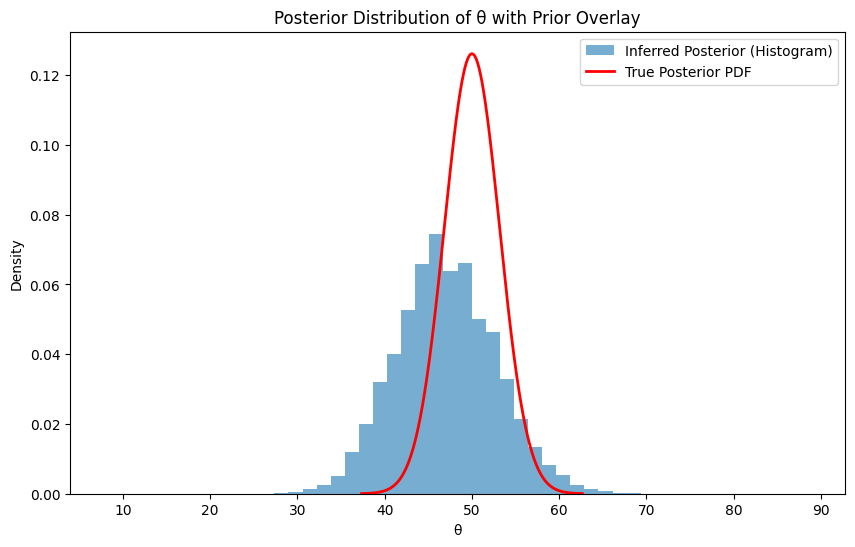

Approx. posterior mean of theta = 47.033


In [27]:
# We need to put the normal distribution far enough into the positive region
# since the Poisson distribution is non-negative
mu0 = 50        # example prior mean
tau2 = 10.0       # example prior variance
y_obs = 45

program_ast = [
    Sample("theta", ("normal", mu0, tau2)),
    Observe(("poisson", Variable("theta")), y_obs)
]

program ="""
(let [theta (sample (normal mu0 tau2))]
  (observe (poisson theta) y_obs)
  theta)
"""

# # Parse
# lexer = FOPPLLexer(program)
# tokens = FOPPLParser(lexer)
# program_ast = tokens.parse()
# print(f'Parsed AST:\n{program_ast}')

# Translate
translator = Translator()
graph = translator.translate_program(program_ast)
sampler = ImportanceSampler(graph)

N = 5000
samples = []
weights = []
for i in range(N):
    env, log_weight = sampler.sample_one()
    samples.append(env)
    weights.append(math.exp(log_weight))  # convert log weight to linear scale

weighted_sum = 0.0
total_weight = 0.0

for env, w in zip(samples, weights):
    weighted_sum += env["theta"] * w
    total_weight += w
posterior_mean_theta = weighted_sum / total_weight

theta_vals = np.array([env["theta"] for env in samples])
weights_array = np.array(weights)

plt.figure(figsize=(10, 6))

# Plot the weighted histogram of posterior samples
counts, bins, _ = plt.hist(theta_vals, bins=50, density=True, weights=weights_array,
                         alpha=0.6, label='Inferred Posterior (Histogram)')

sigma0 = math.sqrt(tau2)

# Create a range of theta values for plotting the prior PDF
theta_range = np.linspace(mu0 - 4*sigma0, mu0 + 4*sigma0, 500)

# Compute the prior PDF for these theta values
prior_pdf = stats.norm.pdf(theta_range, loc=mu0, scale=sigma0)

# Plot the prior PDF
plt.plot(theta_range, prior_pdf, 'r-', lw=2, label='True Posterior PDF')

plt.xlabel('θ')
plt.ylabel('Density')
plt.title('Posterior Distribution of θ with Prior Overlay')
plt.legend()
plt.show()

print(f"Approx. posterior mean of theta = {posterior_mean_theta:.3f}")

## Importance sampling for model 1.7

In [6]:
alpha = 1.0
beta_val = 1.0
p = 0.6 # probability of success
# Generate observations from a Bernoulli distribution
observations = np.random.binomial(1, p, size=500).astype(bool)

program_ast = [
    Sample("theta", ("beta", alpha, beta_val)),
    Observe(("poisson", Variable("theta")), y_obs)
]
for y in observations:
    program_ast.append(Observe(("bernoulli", Variable("theta")), y))


# program = """
# (let [theta (sample (beta 1.0 1.0))]
#   (observe (bernoulli theta) false)
#   (observe (bernoulli theta) false)
#   (observe (bernoulli theta) true)
#   ...
#   theta)
# """

# # Parse
# lexer = FOPPLLexer(program)
# tokens = FOPPLParser(lexer)
# program_ast = tokens.parse()
# print(f'Parsed AST:\n{program_ast}')

# Translate
translator = Translator()
graph = translator.translate_program(program_ast)
sampler = ImportanceSampler(graph)

N = 5000
samples = []
weights = []
for i in range(N):
    env, log_weight = sampler.sample_one()
    samples.append(env)
    weights.append(math.exp(log_weight))  # convert log weight to linear scale

weighted_sum = 0.0
total_weight = 0.0

for env, w in zip(samples, weights):
    weighted_sum += env["theta"] * w
    total_weight += w
posterior_mean_theta = weighted_sum / total_weight

# Extract theta values and weights from samples for plotting
theta_vals = np.array([env["theta"] for env in samples])
weights_array = np.array(weights)

# Plot inferred posterior histogram with weighted samples
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(theta_vals, bins=50, density=True, weights=weights_array,
                         alpha=0.6, label='Inferred Posterior (Histogram)')

# Compute the true posterior parameters analytically
successes = sum(1 for y in observations if y)
failures = len(observations) - successes
true_alpha = alpha + successes
true_beta = beta_val + failures

# Define a range for theta values within [0, 1]
theta_range = np.linspace(0, 1, 500)

# Compute the analytic (true) posterior PDF
true_posterior_pdf = stats.beta.pdf(theta_range, true_alpha, true_beta)

# Plot the analytic true posterior PDF
plt.plot(theta_range, true_posterior_pdf, 'r-', lw=2, label='True Posterior PDF')

plt.xlabel('θ')
plt.ylabel('Density')
plt.title('Inferred vs. True Posterior Distribution of θ')
plt.legend()
plt.show()

print(f"Approx. posterior mean of theta = {posterior_mean_theta:.3f}")

ValueError: Unknown expression type: mu + tau * eta_{i}

Importance Sampling eight school problem


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

# Constants and data
J = 8  # Number of schools
y_obs = np.array([28, 8, -3, 7, -1, 1, 18, 12])  # Observed effects
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])  # Known standard errors

# Prior parameters
mu_prior_mean = 0
mu_prior_sd = 10
tau_prior_scale = 25  # Half-Cauchy scale

# Program AST representation
prog = [
    Sample("mu", ("normal", mu_prior_mean, mu_prior_sd)),
    Sample("tau", ("half-cauchy", tau_prior_scale)),
]

for i in range(J):
    # Sample eta_i from normal(0, 1)
    prog.append(Sample(f"eta_{i}", ('normal', 0.0, 1.0)))
    
    # Directly sample y_i based on theta_i = mu + tau * eta_i
    prog.append(Observe(
        ('normal', 
         ('+', Variable('mu'), ('*', Variable('tau'), Variable(f'eta_{i}'))),  # theta_i = mu + tau * eta_i
         sigma[i]**2), y_obs[i])  # Likelihood of y_i given theta_i and sigma_i^2
)

# Translate and sample
translator = Translator()
graph = translator.translate_program(program_ast)
sampler = ImportanceSampler(graph)

N = 5000  # Number of samples
samples = []
weights = []
for _ in range(N):
    env, log_weight = sampler.sample_one()
    samples.append(env)
    weights.append(math.exp(log_weight))  # Convert log weight to linear scale

# Compute posterior means
weighted_sums = {key: 0.0 for key in ["mu", "tau"] + [f"theta_{i}" for i in range(J)]}
total_weight = 0.0
for env, w in zip(samples, weights):
    for key in weighted_sums:
        weighted_sums[key] += env[key] * w
    total_weight += w
posterior_means = {key: weighted_sums[key] / total_weight for key in weighted_sums}

# Plotting posterior distributions for mu and tau
mu_vals = np.array([env["mu"] for env in samples])
tau_vals = np.array([env["tau"] for env in samples])
weights_array = np.array(weights)

plt.figure(figsize=(14, 6))

# Posterior histogram for mu
plt.subplot(1, 2, 1)
plt.hist(mu_vals, bins=50, density=True, weights=weights_array, alpha=0.6, label="Posterior (Histogram)")
mu_range = np.linspace(-30, 30, 500)
prior_pdf_mu = stats.norm.pdf(mu_range, loc=mu_prior_mean, scale=mu_prior_sd)
plt.plot(mu_range, prior_pdf_mu, 'r-', lw=2, label='Prior PDF')
plt.title("Posterior Distribution of μ")
plt.xlabel("μ")
plt.ylabel("Density")
plt.legend()

# Posterior histogram for tau
plt.subplot(1, 2, 2)
plt.hist(tau_vals, bins=50, density=True, weights=weights_array, alpha=0.6, label="Posterior (Histogram)")
tau_range = np.linspace(0, 50, 500)
prior_pdf_tau = stats.halfcauchy.pdf(tau_range, loc=0, scale=tau_prior_scale)
plt.plot(tau_range, prior_pdf_tau, 'r-', lw=2, label='Prior PDF')
plt.title("Posterior Distribution of τ")
plt.xlabel("τ")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

# Results
print("Posterior means:")
for key, value in posterior_means.items():
    print(f"{key} = {value:.3f}")


NotImplementedError: Distribution half-cauchy not supported.